### Logging imports and setup

In [47]:
LOGS_FOLDER = "logs"

import logging
from time import sleep, strftime, localtime, time

from pathlib import Path
Path(LOGS_FOLDER).mkdir(parents=True, exist_ok=True)

def timestamp():
    return strftime("%Y_%m_%d_%H_%M_%S", localtime())

logging.basicConfig(filename=f'{LOGS_FOLDER}/log_{timestamp()}.txt',filemode='a',format='%(asctime)s - %(name)s - %(levelname)s - %(funcName)s() - %(message)s',level=logging.INFO)

def print_n_log(string):
    print(string)
    logging.info(string)


### Imports

In [53]:
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchvision import datasets

from matplotlib import pyplot as plt

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x: x

import torch
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 3060 Laptop GPU'

### Loading data

In [54]:
PATH_DATA = '../../../data'

noisy_imgs_1, noisy_imgs_2 = torch.load(PATH_DATA + '/train_data.pkl')

noisy_imgs, clean_imgs = torch.load(PATH_DATA + '/val_data.pkl')

In [55]:
noisy_imgs_1.shape, noisy_imgs_2.shape

(torch.Size([50000, 3, 32, 32]), torch.Size([50000, 3, 32, 32]))

In [56]:
noisy_imgs.shape, clean_imgs.shape

(torch.Size([1000, 3, 32, 32]), torch.Size([1000, 3, 32, 32]))

In [57]:
train_input,train_target=noisy_imgs_1.float()/255.0,noisy_imgs_2.float()/255.0
test_input,test_target=noisy_imgs.float()/255.0,clean_imgs.float()/255.0

In [58]:
test_input=test_input.to(device)
test_target=test_target.to(device)
train_input=train_input.to(device)
train_target=train_target.to(device)
None

### Taking a small sample of data for fast training/expermientation. Comment if not needed

In [59]:
# def subsample(tensor):
#     n_samples = tensor.size(dim=0)
#     return tensor[0:n_samples // 10]

# train_input = subsample(train_input)
# train_target = subsample(train_target)

# train_input.shape, train_target.shape

### Basic data exploration

In [60]:
def show_image(image_tensor):
    plt.imshow(image_tensor.permute(1, 2, 0))
    plt.show()


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

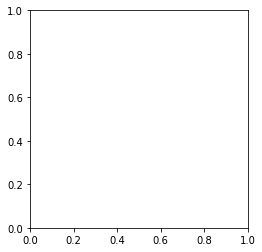

In [61]:
show_image(train_input[0])
show_image(train_target[0])

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

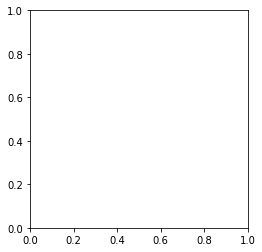

In [62]:
show_image(test_input[0])
show_image(test_target[0])

### Model, optimizer and loss function definitions

In [63]:
# michaelsmac, 1/10 training samples, 10 Epochs, 11s, psnr=23.74
model1 = nn.Sequential(
    nn.Linear(32, 128),
    nn.Linear(128, 32)
)

# tikonGPU, all training samples, 50 Epochs, 100 batch_size, 45 sec, psnr=24.46
model_tikhon=nn.Sequential(
    nn.Linear(32, 128),
    nn.ReLU(),
    nn.Conv2d(3,3,2),
    nn.ReLU(),
    nn.ConvTranspose2d(3,3,2),
    nn.ReLU(),    
    nn.Linear(128, 32)
)

# michaelsmac, 1/10 training samples, 10 Epochs, 36s, psnr=24.75
model2 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=3),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=3),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 34s, psnr=24.72
model2v1 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 34s, psnr=24.73
model2v2 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=3, bias=False),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 41s, psnr=23.56
model3 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=3),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=3),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 1m, psnr=24.80
# michaelsmac, all training samples, 10 Epochs, 1m, psnr=24.80
# tikhonGPU, all training samples, 50 Epochs, 100 batch_size, psnr=25.17, time~50 sec
# tikhonGPU, all training samples, 50 Epochs, 20 batch_size, psnr=25.18, time~2 min

model4 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=3),
    nn.ReLU(),
    nn.ConvTranspose2d(64, 3, kernel_size=3, padding=3),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 1.5m, psnr=24.73
model5 = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size=3, padding=3),
    nn.ReLU(),
    nn.ConvTranspose2d(128, 3, kernel_size=3, padding=3),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 13m, psnr=25.01
model6 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=3),
    nn.ReLU(),
    nn.Conv2d(32, 128, kernel_size=3, padding=3),
    nn.ReLU(),
    nn.ConvTranspose2d(128, 32, kernel_size=3, padding=3),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=3),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 5m, psnr=24.31
model_polling1 = nn.Sequential(
    # 1st layer
    nn.Conv2d(3, 32, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),

    # Max pool 2x2
    nn.MaxPool2d(2, 2), # check ceil_mode=False

    #3nd layer
    nn.Conv2d(32, 128, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),

    #4th layer
    nn.ConvTranspose2d(128, 32, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),

    # Up-conv 2x2
    nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, bias=False),

    #6th layer
    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),
)

# tikonGPU, all training samples, 50 Epochs, 100 batch_size, 5 min, psnr=25.57 (25.5 after 30 epochs)
model_cezary = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, 3, padding=1),
            nn.ReLU(inplace=1),
            nn.Conv2d(48, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1)
        )

In [64]:
# model = model1; print_n_log(f'=== Using model1 ===')
# model = model2; print_n_log(f'=== Using model2 ===')
# model = model2v1; print_n_log(f'=== Using model2v1 ===')
# model = model2v2; print_n_log(f'=== Using model2v2 ===')
# model = model3; print_n_log(f'=== Using model3 ===')
# model = model4; print_n_log(f'=== Using model4 ===')
# model = model5; print_n_log(f'=== Using model5 ===')
# model = model_polling1; print_n_log(f'=== Using model_polling1 ===')
#model = model_tikhon; print_n_log(f'=== Using model_tikhon ===')
model = model_cezary; print_n_log(f'=== Using model_cezary ===')



model.to(device)

=== Using model_cezary ===


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU(inplace=True)
  (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): LeakyReLU(negative_slope=0.1)
)

In [65]:
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
# optimizer=torch.optim.SGD(model.parameters(), lr=1e-3)
loss_fn=nn.MSELoss().to(device)

In [66]:
def psnr(denoised,ground_truth):
    mse=torch.mean((denoised-ground_truth)**2)
    return  - 10 * torch.log10(((denoised-ground_truth) ** 2).mean((1,2,3))).mean()

### Model training and testing

In [67]:
batch_size = 100
nb_epochs = 50

for e in range(nb_epochs):
    print_n_log(f'Epoch -> {e}')
    losses=[]
    start_time = time.time()
    # Run optimization alg for all batches of data
    for b in range(0,train_input.size(0),batch_size):

        # Compute prediction error on batch
        pred = model(train_input.narrow(0, b, batch_size))
        loss = loss_fn(pred, train_target.narrow(0, b, batch_size))
        losses.append(loss)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    current_time = time.time()
    elapsed_time = current_time - start_time
    print_n_log('Time----->{} seconds'.format(elapsed_time))
    print_n_log(f'\tloss={sum(losses)/(train_input.size(0)/batch_size)}')

    # Print test psnr
    with torch.no_grad():
        print_n_log(f'\tpsnr={psnr(model(test_input), test_target)}')

Epoch -> 0
Time----->10.363819360733032 seconds
	loss=0.020038984715938568
	psnr=24.77751922607422
Epoch -> 1
Time----->10.348289728164673 seconds
	loss=0.01486765593290329
	psnr=24.640602111816406
Epoch -> 2
Time----->10.37567400932312 seconds
	loss=0.014747635461390018
	psnr=25.046382904052734
Epoch -> 3
Time----->10.414229154586792 seconds
	loss=0.014695584774017334
	psnr=25.025821685791016
Epoch -> 4
Time----->10.424827575683594 seconds
	loss=0.014656106010079384
	psnr=25.08262825012207
Epoch -> 5
Time----->10.439380645751953 seconds
	loss=0.014627950266003609
	psnr=25.06402587890625
Epoch -> 6
Time----->10.469139814376831 seconds
	loss=0.014605576172471046
	psnr=25.06627082824707
Epoch -> 7
Time----->10.480340480804443 seconds
	loss=0.014577943831682205
	psnr=25.085718154907227
Epoch -> 8
Time----->10.485259771347046 seconds
	loss=0.014563570730388165
	psnr=25.090652465820312
Epoch -> 9
Time----->10.48894715309143 seconds
	loss=0.014547334052622318
	psnr=25.183351516723633
Epoch -